# Best and Worst Results

Pulling out the best and worst results graph maker to here so it's cleaner

In [1]:
import analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
import wandb
import yaml
from constants import DATASET_NAMES, MAX_SIZES

In [2]:
# Load the data
api = wandb.Api()
datasets = list(MAX_SIZES.keys())
train_data = utils.get_data(api, "train", datasets)
metric_data = utils.get_data(api, "metrics", datasets)
data = metric_data.merge(train_data, on=["dataset_name", "model_name", "n_samples"])

# Read in imagenet validation accuracies
with open("../configs/scores_imagenet1k.yaml") as f:
    imagenet = yaml.safe_load(f)
imagenet = [
    {"model_name": key, "imagenet-validation": {"score": imagenet[key]}}
    for key in imagenet.keys()
]
imagenet = pd.DataFrame(imagenet)

# Merge in imagenet val acc
data = data.merge(imagenet, on="model_name")

# Multiply test accuracy by 100 for regret computation
data["test_accuracy"] = data["test_accuracy"] * 100

In [3]:
# Compute all correlations accross different dataset sizes
group_data = data.groupby(["dataset_name", "n_samples", "n_metric_samples"])
metrics = ["renggli", "LogME", "n_pars", "imagenet-validation"]
corr_tables = []
for met in metrics:
    corr_tables.append(analysis.get_correlations(group_data, met))

In [4]:
# Compute all regrets across different dataset sizes
regret_tables = []
for met in metrics:
    regret_tables.append(analysis.get_regrets(group_data, met, 1))

In [5]:
metric_names = {}
metric_names["renggli"] = ("Renggli", 0)
metric_names["LogME"] = ("LogME", 1)
metric_names["n_pars"] = ("N. Params", 2)
metric_names["imagenet-validation"] = ("ImageNet Acc.", 3)
metric_names

{'renggli': ('Renggli', 0),
 'LogME': ('LogME', 1),
 'n_pars': ('N. Params', 2),
 'imagenet-validation': ('ImageNet Acc.', 3)}

In [6]:
# Extract correlation from correlation tables
for metric in metric_names.keys():
    corr_tables[metric_names[metric][1]][metric] = [
        v[0] for v in corr_tables[metric_names[metric][1]][metric].values
    ]

In [7]:
corr_tables[0]

,dataset,n_samples,n_metric_samples,renggli
0,VG Faucet,500,500,0.440102
1,VG Faucet,1000,500,0.711565
2,VG Faucet,1000,1000,0.540392
3,VG Faucet,2303,500,0.090185
4,VG Faucet,2303,1000,0.277018
...,...,...,...,...
58,Oxford Pets,1000,500,0.248862
59,Oxford Pets,1000,1000,0.354885
60,Oxford Pets,4803,500,0.397940
61,Oxford Pets,4803,1000,0.361219


In [8]:
def get_best_worst_metric(correlations, metric):
    """Return the best and worst results for a given metric, return a triple of
        (dataset, n_samples, n_metric_samples)

    Args:
        correlations: correlation results
    """
    return (
        (
            correlations[correlations[metric] == correlations[metric].max()],
            correlations[metric].max(),
        ),
        (
            correlations[correlations[metric] == correlations[metric].min()],
            correlations[metric].min(),
        ),
    )

In [9]:
def get_dataset_name_from_dataset(dataset):
    for pair in list(DATASET_NAMES.items()):
        if pair[1] == dataset:
            return pair[0]

In [10]:
def extract_best_worst_raw_data(run_data, best_run):
    return run_data[
        (
            run_data["dataset_name"]
            == get_dataset_name_from_dataset(best_run["dataset"].values[-1])
        )
        & (run_data["n_samples"] == best_run["n_samples"].values[-1])
        & (run_data["n_metric_samples"] == best_run["n_metric_samples"].values[-1])
    ]

In [53]:
def plot_best_worst_metric(correlations, run_data, ylim=(50, 85), fig_size=(15, 30)):
    """Plot all the pairs of best and worst metrics for correlations"""
    fig, ax = plt.subplots(4, 2, figsize=fig_size, constrained_layout=True)
    for idx, metric in enumerate(metric_names.keys()):
        (best_run, best_corr), (worst_run, worst_corr) = get_best_worst_metric(
            correlations[metric_names[metric][1]], metric
        )
        best_data = extract_best_worst_raw_data(run_data, best_run)
        worst_data = extract_best_worst_raw_data(run_data, worst_run)

        # Plot scatter plots
        best_scores = np.asarray([v["score"] for v in best_data[metric].values])
        best_acc = best_data["test_accuracy"].values
        ax[idx, 0].scatter(best_scores, best_acc)

        worst_scores = np.asarray([v["score"] for v in worst_data[metric].values])
        worst_acc = worst_data["test_accuracy"].values
        ax[idx, 1].scatter(worst_scores, worst_acc)

        # Plot max points
        best_picked_idx = np.argmax(best_scores)
        best_trained_idx = np.argmax(best_acc)
        ax[idx, 0].scatter(
            best_scores[best_picked_idx],
            best_acc[best_picked_idx],
            marker="P",
            s=100,
            label="Metric Selected Model",
        )
        ax[idx, 0].scatter(
            best_scores[best_trained_idx],
            best_acc[best_trained_idx],
            marker="P",
            s=100,
            label="Fine-Tuning Selected Model",
        )

        worst_picked_idx = np.argmax(worst_scores)
        worst_trained_idx = np.argmax(worst_acc)
        ax[idx, 1].scatter(
            worst_scores[worst_picked_idx],
            worst_acc[worst_picked_idx],
            marker="P",
            s=100,
            label="Metric Selected Model",
        )
        ax[idx, 1].scatter(
            worst_scores[worst_trained_idx],
            worst_acc[worst_trained_idx],
            marker="P",
            s=100,
            label="Fine-Tuning Selected Model",
        )

        # Axis scale
        # ax[idx, 0].set_ylim(ylim[0], ylim[1])
        # ax[idx, 1].set_ylim(ylim[0], ylim[1])

        # Axis labels
        ax[idx, 0].set_xlabel(f"{metric_names[metric][0]} Metric Score", fontsize=20)
        ax[idx, 1].set_xlabel(f"{metric_names[metric][0]} Metric Score", fontsize=20)
        ax[idx, 0].set_ylabel("Post Fine-Tuning Test Accuracy")
        ax[idx, 1].set_ylabel("Post Fine-Tuning Test Accuracy")

        # Plot Titles
        btitle1 = f"Best {metric_names[metric][0]} Result vs. Test Acc."
        btitle2 = f"\n{best_run['dataset'].values[-1]}, "
        btitle3 = f"{best_run['n_samples'].values[-1]} training images"
        btitle4 = f",\n {best_run['n_metric_samples'].values[-1]} metric images "
        if metric == "n_pars" or metric == "imagenet-validation":
            btitle4 = " "
        btitle5 = f"\ncorrelation = {np.around(best_corr, 2)}"
        ax[idx, 0].set_title(
            btitle1 + btitle2 + btitle3 + btitle4 + btitle5, fontsize=25
        )

        wtitle1 = f"Worst {metric_names[metric][0]} Result vs. Test Acc."
        wtitle2 = f"\n{worst_run['dataset'].values[-1]}, "
        wtitle3 = f"{worst_run['n_samples'].values[-1]} training images"
        wtitle4 = f",\n {worst_run['n_metric_samples'].values[-1]} metric images "
        if metric == "n_pars" or metric == "imagenet-validation":
            wtitle4 = " "
        wtitle5 = f"\ncorrelation = {np.around(worst_corr, 2)}"
        ax[idx, 1].set_title(
            wtitle1 + wtitle2 + wtitle3 + wtitle4 + wtitle5, fontsize=25
        )
        ax[idx, 0].tick_params(axis="both", which="major", labelsize=15)
        ax[idx, 0].tick_params(axis="both", which="minor", labelsize=15)
        ax[idx, 1].tick_params(axis="both", which="major", labelsize=15)
        ax[idx, 1].tick_params(axis="both", which="minor", labelsize=15)
    handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
    unique = [
        (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    ]
    fig.legend(*zip(*unique), fontsize=20, bbox_to_anchor=(1.25, 0.95))
    fig.savefig("../results/report_plots/best_worst.svg")
    # fig.tight_layout()

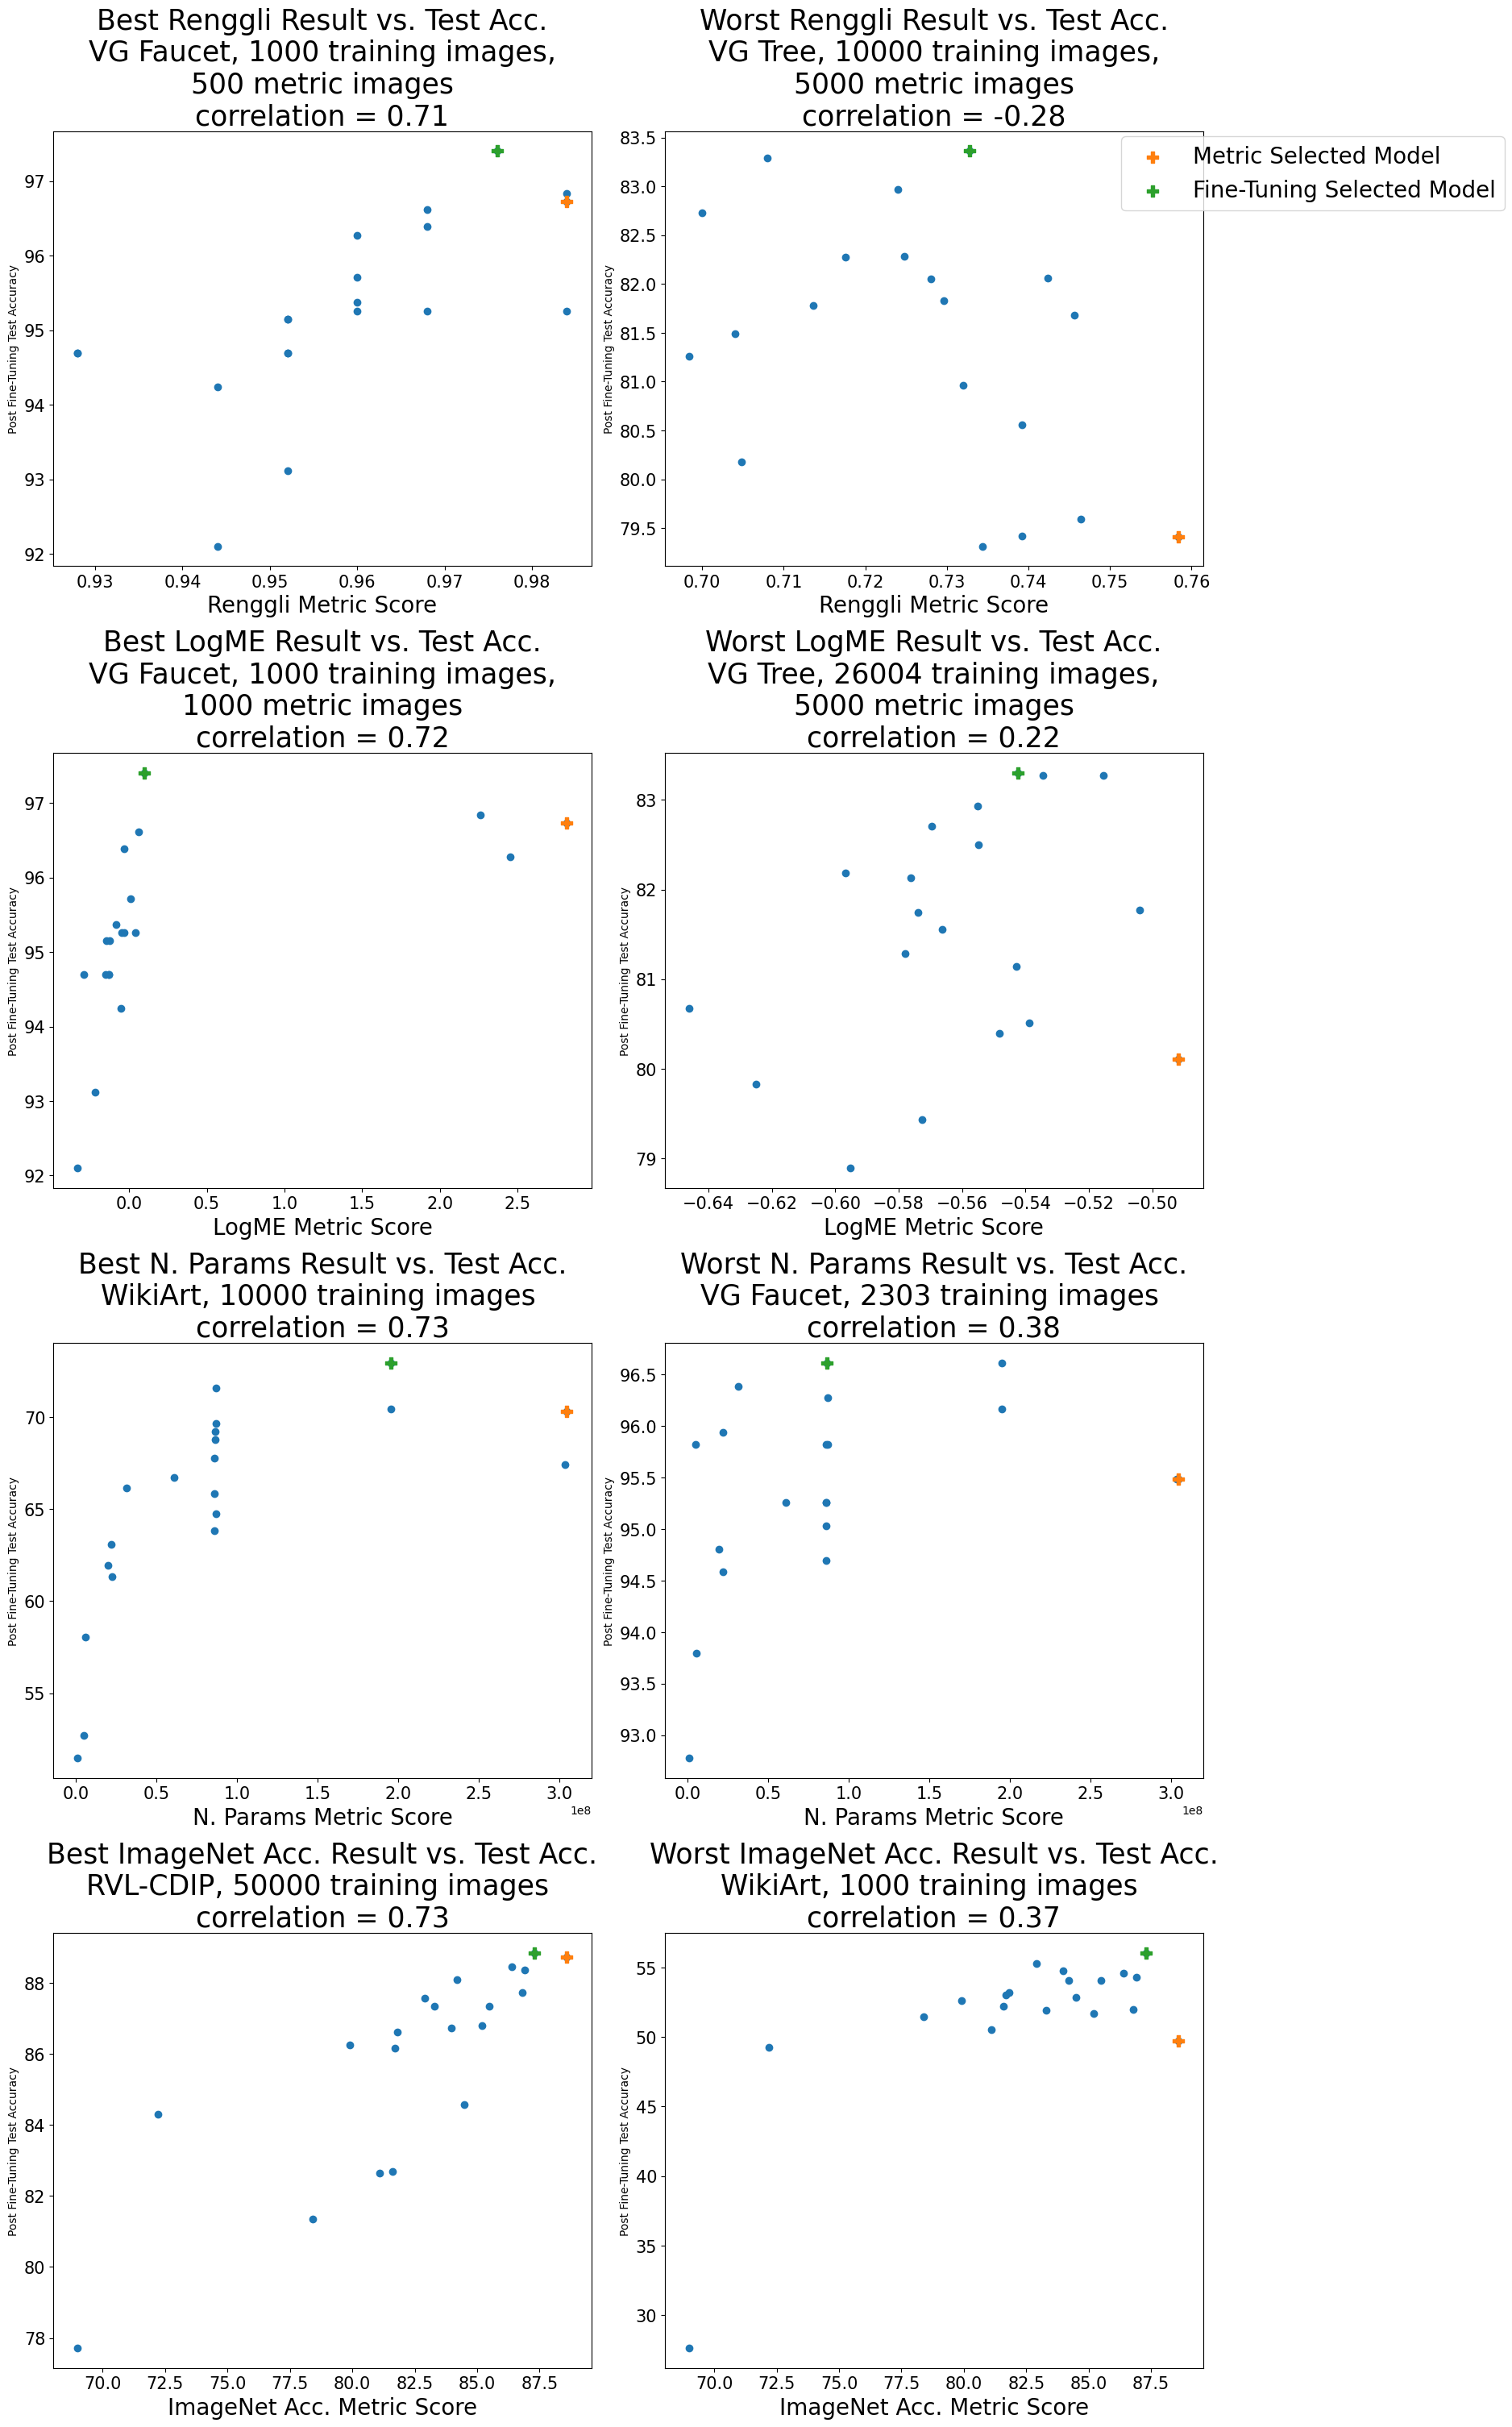

In [54]:
plot_best_worst_metric(corr_tables, data, ylim=(0.0, 100.0))

## Also want this but with the ranking instead of raw scores

In [34]:
# Example
(best_run, _), (_, _) = get_best_worst_metric(corr_tables[0], "renggli")
print(best_run)
best_data = extract_best_worst_raw_data(data, best_run)

     dataset  n_samples  n_metric_samples   renggli
1  VG Faucet       1000               500  0.711565


In [35]:
# Add rank columns for best data
best_data["renggli"] = np.asarray([v["score"] for v in best_data["renggli"].values])
best_data["renggli_rank"] = best_data["renggli"].rank()

/var/folders/nv/1rqqc6xx095gwdgy0bycy1z80000gr/T/ipykernel_18548/2466536335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_data["renggli"] = np.asarray([v["score"] for v in best_data["renggli"].values])
/var/folders/nv/1rqqc6xx095gwdgy0bycy1z80000gr/T/ipykernel_18548/2466536335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_data["renggli_rank"] = best_data["renggli"].rank()


In [36]:
best_data

,dataset_name,model_name,n_samples,n_metric_samples,LogME,n_pars,renggli,inference_times,test_accuracy,train_runtime,eval_runtime,imagenet-validation,renggli_rank
37,/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMo...,facebook/dinov2-base-imagenet1k-1-layer,1000,500,"{'score': 10.460314269775978, 'time': 0.213925...","{'score': 86580480, 'time': 0.000865936279296875}",0.984,15.045875,96.726862,294.9144,4.1991,{'score': 84.5},19.0
100,/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMo...,facebook/dinov2-small-imagenet1k-1-layer,1000,500,"{'score': 2.7375602369211074, 'time': 0.127957...","{'score': 22056576, 'time': 0.0008401870727539...",0.984,15.629115,95.259594,222.1995,3.5274,{'score': 81.1},19.0
163,/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMo...,Zetatech/pvt-large-224,1000,500,"{'score': -0.0031017634881997103, 'time': 0.07...","{'score': 60856320, 'time': 0.0022459030151367...",0.952,13.524072,95.146727,354.6687,4.0065,{'score': 81.7},7.0
226,/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMo...,microsoft/swinv2-large-patch4-window12to16-192...,1000,500,"{'score': 9.212719413310309, 'time': 0.1423408...","{'score': 195202932, 'time': 0.001620292663574...",0.960,17.812274,96.275395,503.4591,5.6102,{'score': 86.9},11.5
289,/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMo...,microsoft/swinv2-base-patch4-window8-256,1000,500,"{'score': 3.672880869182803, 'time': 0.1652455...","{'score': 86893816, 'time': 0.001647233963012695}",0.960,15.256966,95.711061,393.9549,4.9270,{'score': 84.2},11.5
352,/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMo...,microsoft/swin-large-patch4-window12-384-in22k,1000,500,"{'score': 8.497609153498255, 'time': 0.1381642...","{'score': 195198516, 'time': 0.001432180404663...",0.984,20.434942,96.839729,831.1103,8.5336,{'score': 87.3},19.0
415,/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMo...,microsoft/swin-base-patch4-window12-384,1000,500,"{'score': 4.351296573447081, 'time': 0.1790087...","{'score': 86878584, 'time': 0.0016112327575683...",0.976,19.564849,97.404063,620.3224,8.1279,{'score': 86.4},17.0
478,/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMo...,microsoft/cvt-21-384,1000,500,"{'score': -0.12152071735297976, 'time': 0.1382...","{'score': 31237696, 'time': 0.0014901161193847...",0.928,17.219220,94.695260,505.8712,7.0230,{'score': 83.3},1.5
541,/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMo...,microsoft/cvt-13,1000,500,"{'score': -0.16063202496091494, 'time': 0.1226...","{'score': 19612480, 'time': 0.0014090538024902...",0.952,16.503795,95.146727,264.4506,3.6755,{'score': 81.6},7.0
604,/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMo...,microsoft/beit-large-patch16-512,1000,500,"{'score': 5.049779258480957, 'time': 0.1240949...","{'score': 304649728, 'time': 0.001233577728271...",0.968,43.935388,96.613995,2220.8738,19.5732,{'score': 88.6},15.0


In [51]:
def plot_best_worst_metric_ranked(
    correlations, run_data, ylim=(50, 85), fig_size=(15, 30), ascending=True
):
    """Plot all the pairs of best and worst metrics for correlations"""
    fig, ax = plt.subplots(4, 2, figsize=fig_size)
    for idx, metric in enumerate(metric_names.keys()):
        (best_run, best_corr), (worst_run, worst_corr) = get_best_worst_metric(
            correlations[metric_names[metric][1]], metric
        )
        best_data = extract_best_worst_raw_data(run_data, best_run)
        worst_data = extract_best_worst_raw_data(run_data, worst_run)

        # Plot scatter plots
        best_data[metric] = np.asarray([v["score"] for v in best_data[metric].values])
        best_data[f"{metric}_rank"] = best_data[metric].rank(ascending=ascending)
        best_data["test_acc_rank"] = best_data["test_accuracy"].rank(
            ascending=ascending
        )
        ax[idx, 0].scatter(
            best_data[f"{metric}_rank"].values, best_data["test_acc_rank"].values
        )

        worst_data[metric] = np.asarray([v["score"] for v in worst_data[metric].values])
        worst_data[f"{metric}_rank"] = worst_data[metric].rank(ascending=ascending)
        worst_data["test_acc_rank"] = worst_data["test_accuracy"].rank(
            ascending=ascending
        )
        ax[idx, 1].scatter(
            worst_data[f"{metric}_rank"].values, worst_data["test_acc_rank"].values
        )

        # Plot max points
        if ascending:
            best_picked_idx = np.argmin(best_data[f"{metric}_rank"].values)
            best_trained_idx = np.argmin(best_data["test_acc_rank"].values)
        else:
            best_picked_idx = np.argmax(best_data[f"{metric}_rank"].values)
            best_trained_idx = np.argmax(best_data["test_acc_rank"].values)
        ax[idx, 0].scatter(
            best_data[f"{metric}_rank"].values[best_picked_idx],
            best_data["test_acc_rank"].values[best_picked_idx],
            marker="P",
            s=100,
            label="Metric Selected Model",
        )
        ax[idx, 0].scatter(
            best_data[f"{metric}_rank"].values[best_trained_idx],
            best_data["test_acc_rank"].values[best_trained_idx],
            marker="P",
            s=100,
            label="Fine-Tuning Selected Model",
        )

        worst_picked_idx = np.argmin(worst_data[f"{metric}_rank"].values)
        worst_trained_idx = np.argmin(worst_data["test_acc_rank"].values)
        ax[idx, 1].scatter(
            worst_data[f"{metric}_rank"].values[worst_picked_idx],
            worst_data["test_acc_rank"].values[worst_picked_idx],
            marker="P",
            s=100,
            label="Metric Selected Model",
        )
        ax[idx, 1].scatter(
            worst_data[f"{metric}_rank"].values[worst_trained_idx],
            worst_data["test_acc_rank"].values[worst_trained_idx],
            marker="P",
            s=100,
            label="Fine-Tuning Selected Model",
        )

        # Axis scale
        # ax[idx, 0].set_ylim(ylim[0], ylim[1])
        # ax[idx, 1].set_ylim(ylim[0], ylim[1])

        # Axis labels
        ax[idx, 0].set_xlabel(
            f"{metric_names[metric][0]} Metric Score Rank", fontsize=20
        )
        ax[idx, 1].set_xlabel(
            f"{metric_names[metric][0]} Metric Score Rank", fontsize=20
        )
        ax[idx, 0].set_ylabel("Post Fine-Tuning Test Accuracy Rank", fontsize=20)
        ax[idx, 1].set_ylabel("Post Fine-Tuning Test Accuracy Rank", fontsize=20)

        # Plot Titles
        btitle1 = f"Best {metric_names[metric][0]} Result vs. Test Acc."
        btitle2 = f"\n{best_run['dataset'].values[-1]}, "
        btitle3 = f"{best_run['n_samples'].values[-1]} training images"
        btitle4 = f",\n {best_run['n_metric_samples'].values[-1]} metric images"
        if metric == "n_pars" or metric == "imagenet-validation":
            btitle4 = " "
        btitle5 = f"\ncorrelation = {np.around(best_corr, 2)}"
        ax[idx, 0].set_title(
            btitle1 + btitle2 + btitle3 + btitle4 + btitle5, fontsize=25
        )

        wtitle1 = f"Worst {metric_names[metric][0]} Result vs. Test Acc."
        wtitle2 = f"\n{worst_run['dataset'].values[-1]}, "
        wtitle3 = f"{worst_run['n_samples'].values[-1]} training images"
        wtitle4 = f",\n {worst_run['n_metric_samples'].values[-1]} metric images"
        if metric == "n_pars" or metric == "imagenet-validation":
            wtitle4 = " "
        wtitle5 = f"\ncorrelation = {np.around(worst_corr, 2)}"
        ax[idx, 1].set_title(
            wtitle1 + wtitle2 + wtitle3 + wtitle4 + wtitle5, fontsize=25
        )

        ax[idx, 0].tick_params(axis="both", which="major", labelsize=15)
        ax[idx, 0].tick_params(axis="both", which="minor", labelsize=15)
        ax[idx, 1].tick_params(axis="both", which="major", labelsize=15)
        ax[idx, 1].tick_params(axis="both", which="minor", labelsize=15)
    handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
    unique = [
        (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    ]
    fig.legend(*zip(*unique), fontsize=20, bbox_to_anchor=(1.25, 0.95))
    fig.tight_layout()
    fig.savefig("../results/report_plots/ranked_best_worst.svg")

/var/folders/nv/1rqqc6xx095gwdgy0bycy1z80000gr/T/ipykernel_18548/2558937077.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_data[metric] = np.asarray([v["score"] for v in best_data[metric].values])
/var/folders/nv/1rqqc6xx095gwdgy0bycy1z80000gr/T/ipykernel_18548/2558937077.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_data[f"{metric}_rank"] = best_data[metric].rank(ascending=ascending)
/var/folders/nv/1rqqc6xx095gwdgy0bycy1z80000gr/T/ipykernel_18548/2558937077.py:16: SettingWithCopyWar

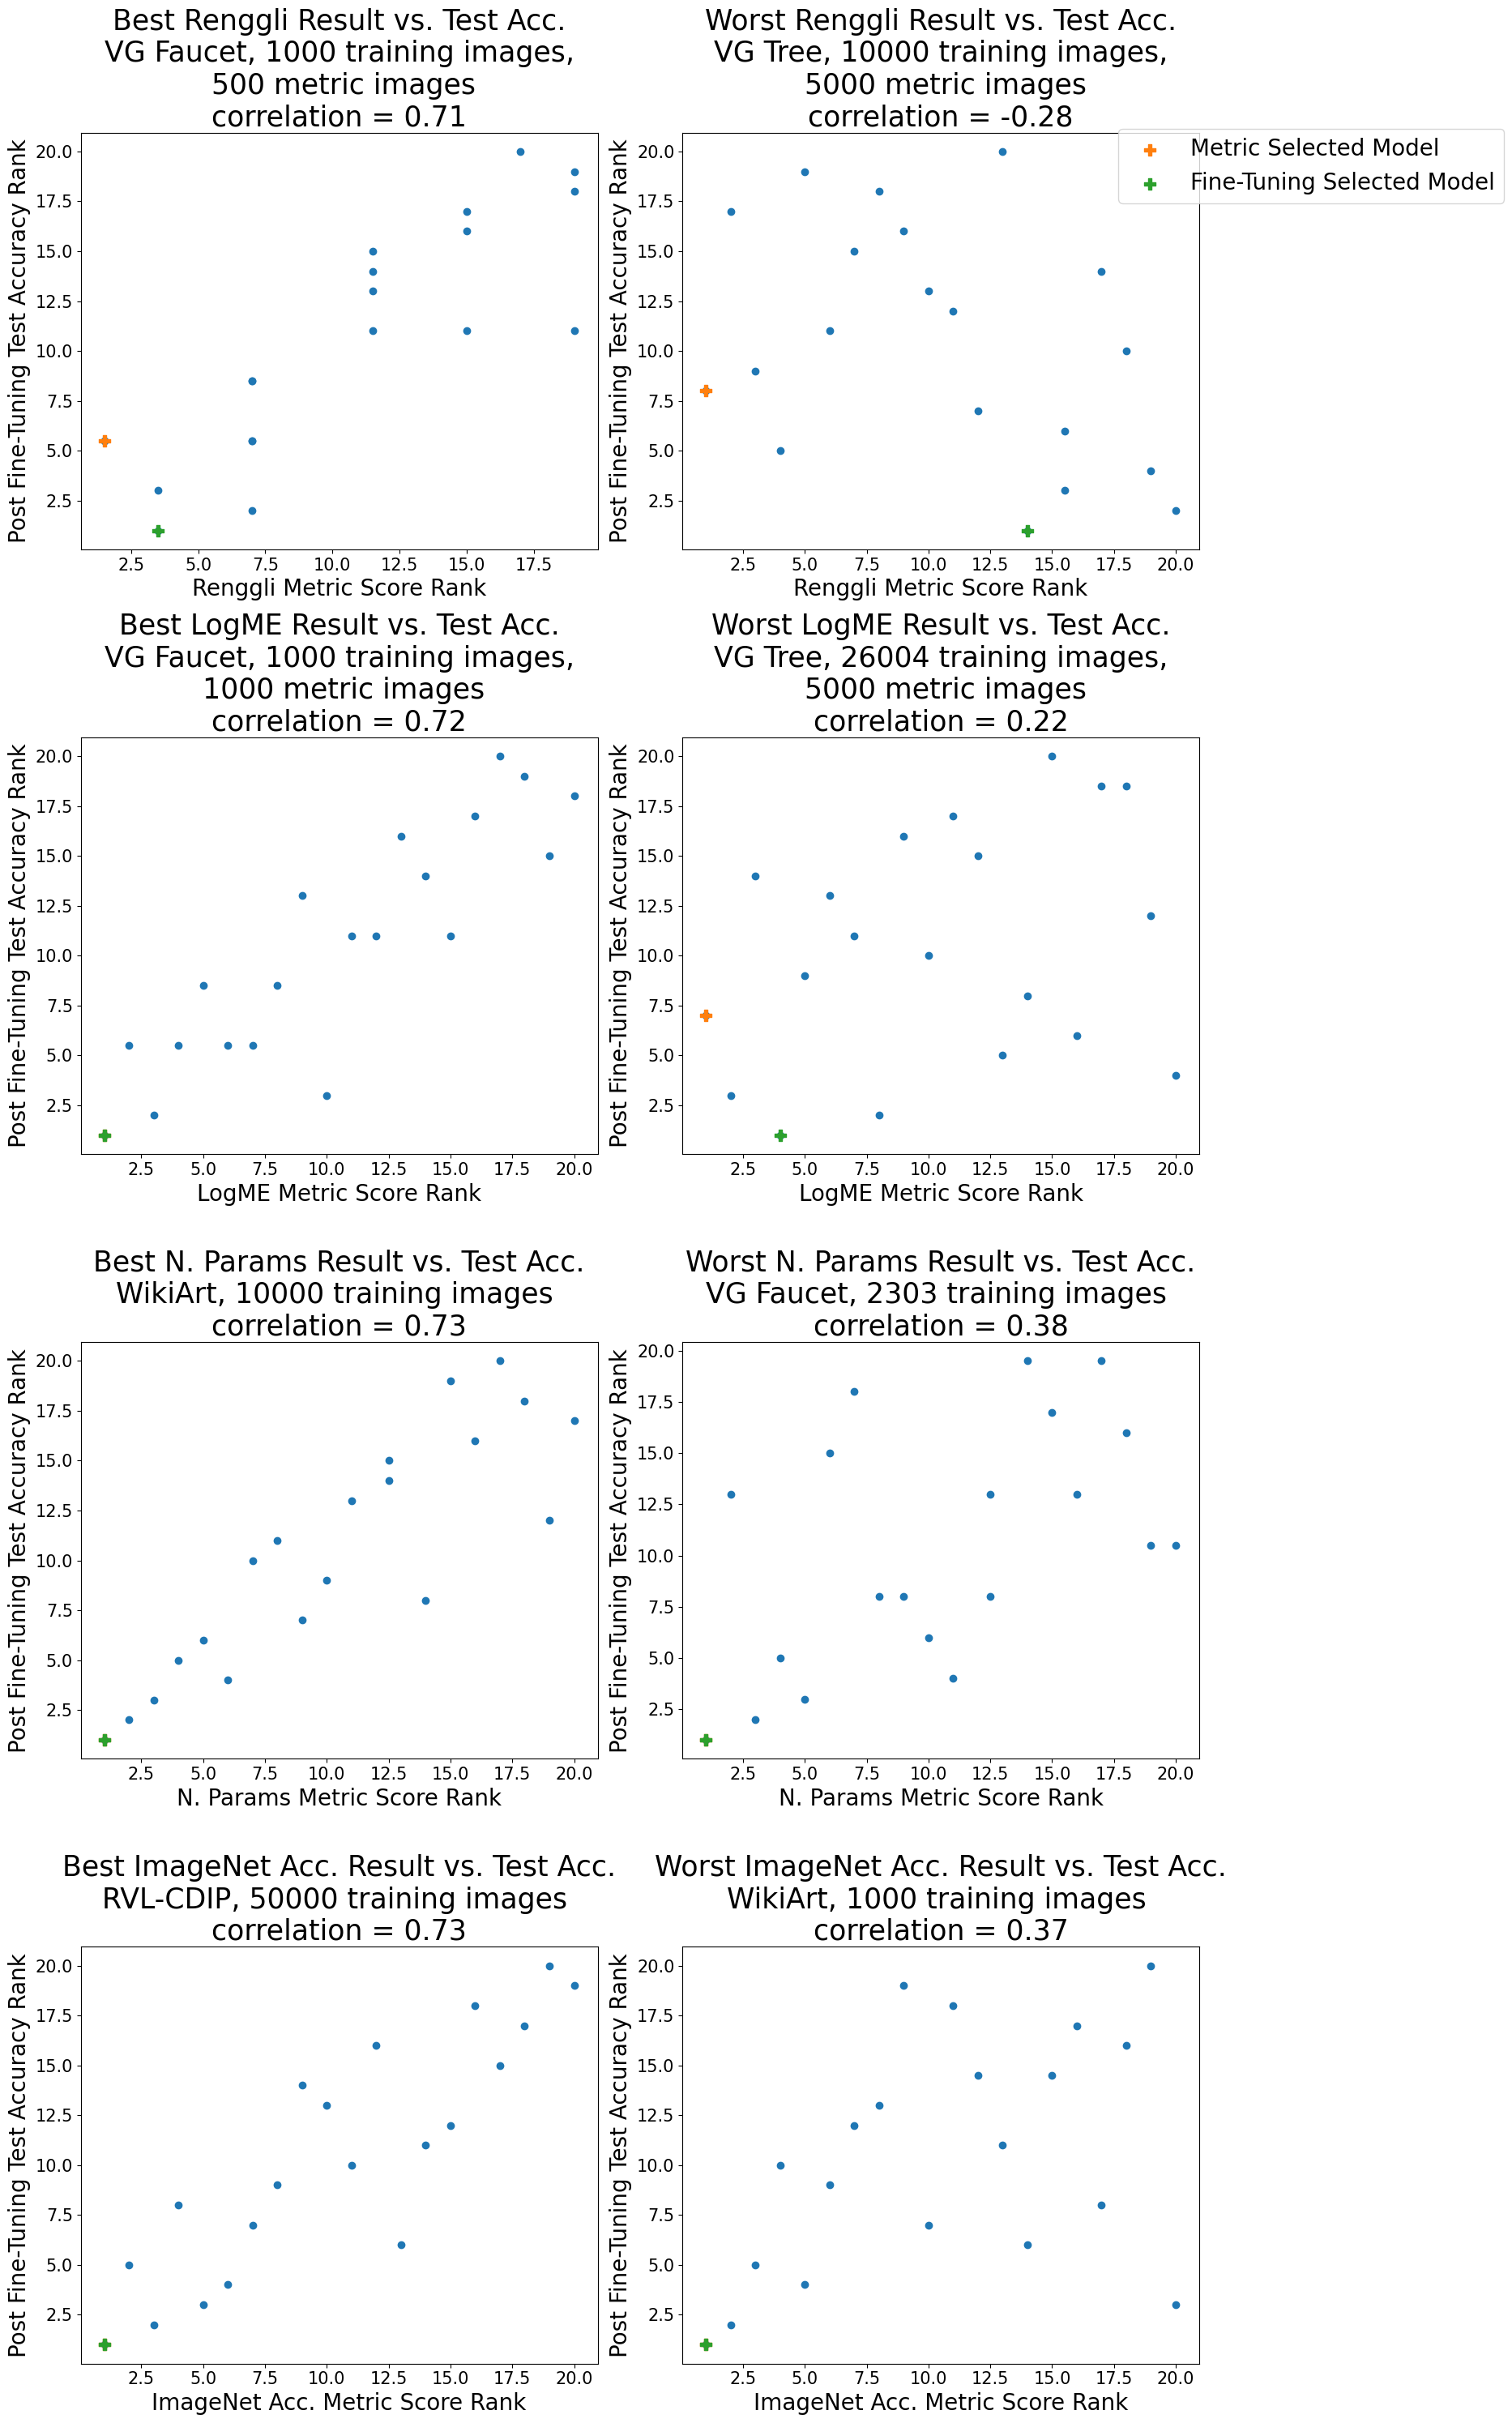

In [52]:
plot_best_worst_metric_ranked(corr_tables, data, ylim=(0.0, 100.0))